# **DBSCAN Clustering**
## **Klasteryzacja DBSCAN**

---

### **Overview / Przegląd**

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a density-based clustering algorithm that groups together points in high-density areas and marks points in low-density areas as outliers.

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) to algorytm klasteryzacji oparty na gęstości, który grupuje punkty w obszarach o wysokiej gęstości i oznacza punkty w obszarach o niskiej gęstości jako wartości odstające.

### **Key Concepts / Kluczowe pojęcia**

1. **Core Point / Punkt rdzeniowy**: Point with at least `min_samples` neighbors within `eps` distance
2. **Border Point / Punkt brzegowy**: Point within `eps` distance of a core point but has fewer than `min_samples` neighbors
3. **Noise Point / Punkt szumu**: Point that is neither core nor border point

### **Algorithm Parameters / Parametry algorytmu**
- **eps (ε)**: Maximum distance between two samples for them to be considered neighbors
- **min_samples**: Minimum number of samples in a neighborhood for a point to be considered core

### **Advantages / Zalety**
- Finds clusters of arbitrary shape / Znajduje klastry o dowolnym kształcie
- Robust to outliers / Odporny na wartości odstające  
- Doesn't require specifying number of clusters / Nie wymaga określania liczby klastrów


In [1]:
# Import required libraries / Importowanie wymaganych bibliotek
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

# Set style for plots / Ustawienie stylu wykresów
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully / Biblioteki zaimportowane pomyślnie")


Libraries imported successfully / Biblioteki zaimportowane pomyślnie


FINISH THE CODE BELOW!!!

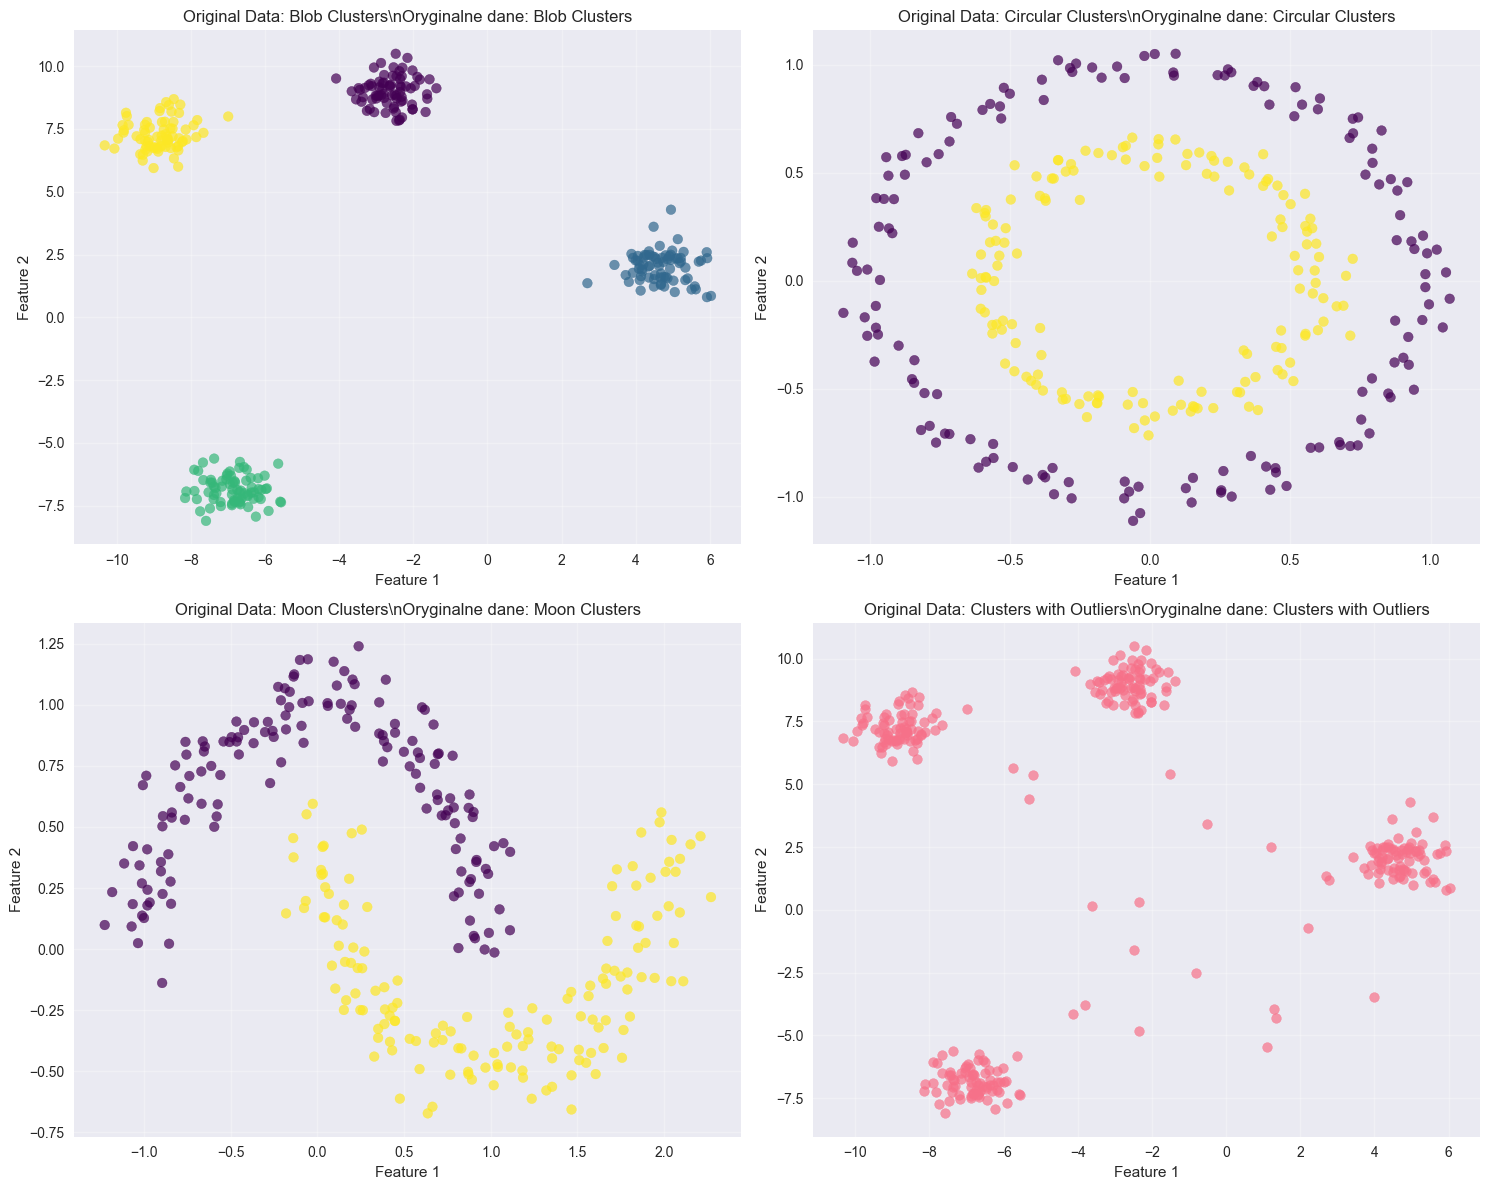

In [2]:
# Create different types of datasets / Tworzenie różnych typów zbiorów danych
np.random.seed(42)

# 1. Blob-shaped clusters / Klastry w kształcie blob
X_blobs, y_blobs = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=42)

# 2. Circular clusters / Klastry kołowe
X_circles, y_circles = make_circles(n_samples=300, noise=0.05, factor=0.6, random_state=42)

# 3. Moon-shaped clusters / Klastry w kształcie księżyca
X_moons, y_moons = make_moons(n_samples=300, noise=0.1, random_state=42)

# 4. Dataset with outliers / Zbiór danych z wartościami odstającymi
X_outliers = np.vstack([X_blobs, np.random.uniform(-6, 6, (20, 2))])

datasets = [
    (X_blobs, y_blobs, "Blob Clusters"),
    (X_circles, y_circles, "Circular Clusters"), 
    (X_moons, y_moons, "Moon Clusters"),
    (X_outliers, None, "Clusters with Outliers")
]

# Visualize original datasets / Wizualizacja oryginalnych zbiorów danych
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, (X, y, title) in enumerate(datasets):
    if y is not None:
        scatter = axes[i].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.7)
    else:
        scatter = axes[i].scatter(X[:, 0], X[:, 1], alpha=0.7)
    
    axes[i].set_title(f'Original Data: {title}\\nOryginalne dane: {title}')
    axes[i].set_xlabel('Feature 1')
    axes[i].set_ylabel('Feature 2')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


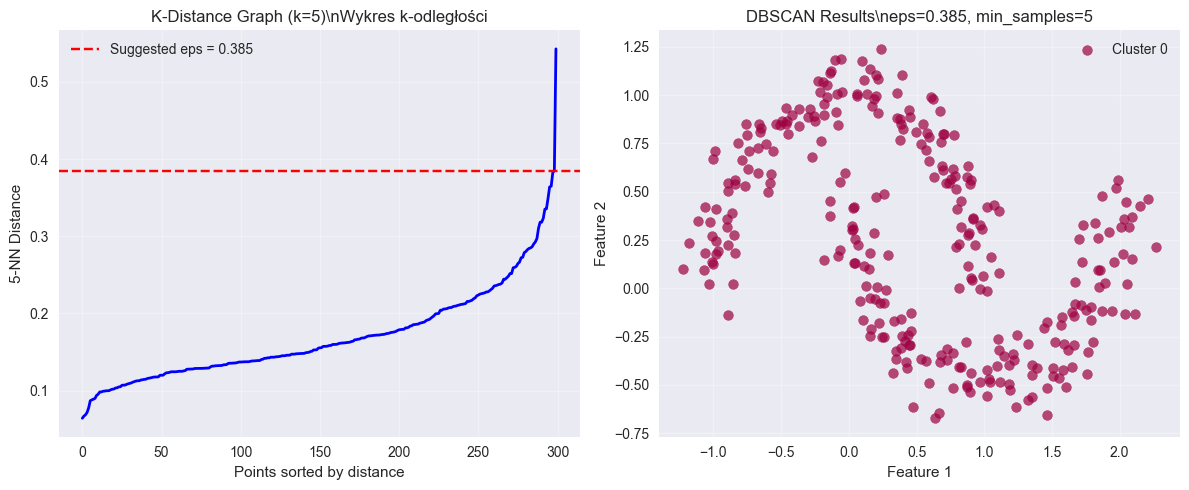

Suggested eps value / Sugerowana wartość eps: 0.385
Number of clusters found / Liczba znalezionych klastrów: 1
Number of noise points / Liczba punktów szumu: 0


In [3]:

# Function to find optimal eps using k-distance graph / Funkcja do znajdowania optymalnego eps
def find_optimal_eps(X, min_samples=5):
    """Find optimal eps parameter using k-distance graph"""
    
    # Calculate k-distances / Obliczenie k-odległości
    neighbors = NearestNeighbors(n_neighbors=min_samples)
    neighbors_fit = neighbors.fit(X)
    distances, indices = neighbors_fit.kneighbors(X)
    
    # Sort distances / Sortowanie odległości
    distances = np.sort(distances[:, min_samples-1], axis=0)
    
    return distances

# Demonstrate eps selection for moons dataset / Demonstracja wyboru eps dla zbioru moons
X_demo = X_moons

# Standardize the data / Standaryzacja danych
scaler = StandardScaler()
X_demo_scaled = scaler.fit_transform(X_demo)

# Find k-distances / Znajdowanie k-odległości
min_samples = 5
distances = find_optimal_eps(X_demo_scaled, min_samples)

# Plot k-distance graph / Wykres k-odległości
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(len(distances)), distances, 'b-', linewidth=2)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{min_samples}-NN Distance')
plt.title(f'K-Distance Graph (k={min_samples})\\nWykres k-odległości')
plt.grid(True, alpha=0.3)

# Add suggested eps line / Dodanie sugerowanej linii eps
knee_point = np.diff(distances).argmax()  # Find the "knee" / Znajdowanie "kolana"
suggested_eps = distances[knee_point]
plt.axhline(y=suggested_eps, color='red', linestyle='--', 
           label=f'Suggested eps = {suggested_eps:.3f}')
plt.legend()

# Apply DBSCAN with suggested eps / Zastosowanie DBSCAN z sugerowanym eps
dbscan = DBSCAN(eps=suggested_eps, min_samples=min_samples)
labels = dbscan.fit_predict(X_demo_scaled)

# Plot DBSCAN results / Wykres wyników DBSCAN
plt.subplot(1, 2, 2)
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Noise points / Punkty szumu
        col = 'black'
        marker = 'x'
        label = 'Noise'
    else:
        marker = 'o'
        label = f'Cluster {k}'
    
    class_member_mask = (labels == k)
    xy = X_demo[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=[col], marker=marker, s=50, alpha=0.7, label=label)

plt.title(f'DBSCAN Results\\neps={suggested_eps:.3f}, min_samples={min_samples}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Suggested eps value / Sugerowana wartość eps: {suggested_eps:.3f}")
print(f"Number of clusters found / Liczba znalezionych klastrów: {len(set(labels)) - (1 if -1 in labels else 0)}")
print(f"Number of noise points / Liczba punktów szumu: {list(labels).count(-1)}")


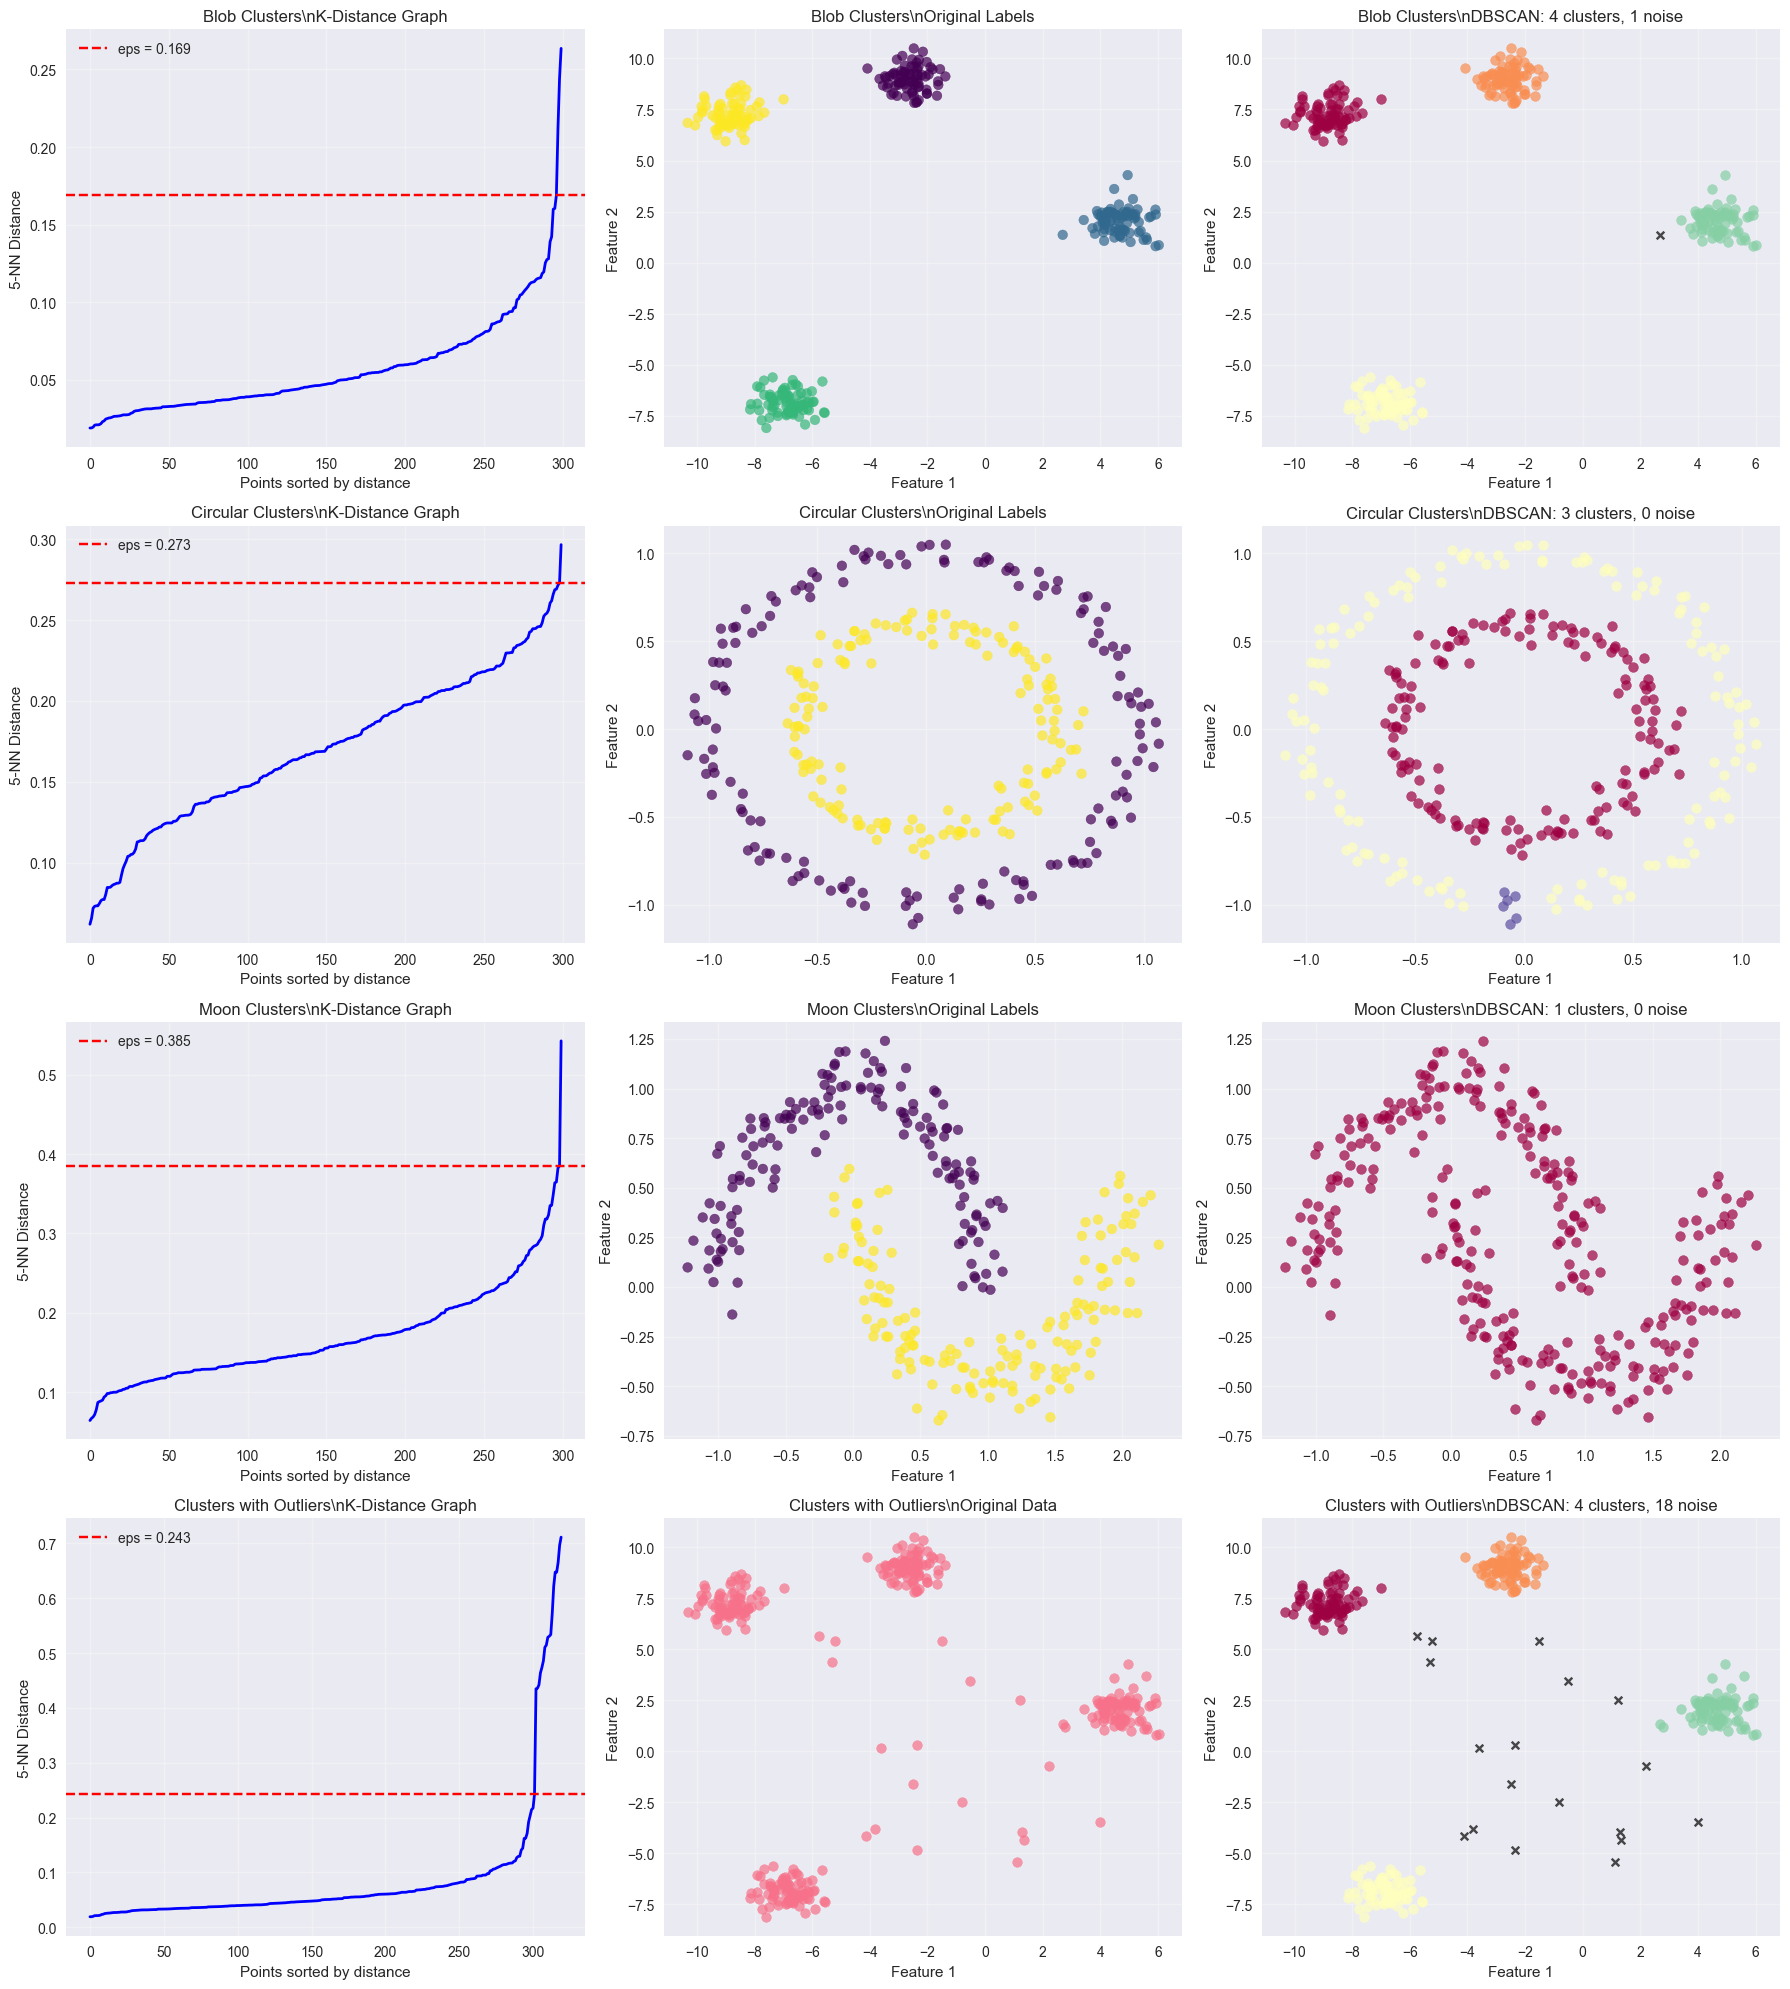

\nDBSCAN Results Summary / Podsumowanie wyników DBSCAN:
               Dataset  Optimal_eps  N_Clusters  N_Noise  Silhouette_Score  ARI_Score
         Blob Clusters       0.1689           4        1            0.7851     0.9956
     Circular Clusters       0.2731           3        0           -0.0589     0.9615
         Moon Clusters       0.3850           1        0           -1.0000     0.0000
Clusters with Outliers       0.2428           4       18            0.8082        NaN


In [4]:
# Apply DBSCAN to all datasets / Zastosowanie DBSCAN do wszystkich zbiorów danych
fig, axes = plt.subplots(4, 3, figsize=(18, 20))

results_summary = []

for i, (X, y_true, title) in enumerate(datasets):
    # Standardize data / Standaryzacja danych
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Find optimal parameters / Znajdowanie optymalnych parametrów
    min_samples = 5
    distances = find_optimal_eps(X_scaled, min_samples)
    knee_point = np.diff(distances).argmax()
    optimal_eps = distances[knee_point]
    
    # Apply DBSCAN / Zastosowanie DBSCAN
    dbscan = DBSCAN(eps=optimal_eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)
    
    # Calculate metrics / Obliczenie metryk
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    if n_clusters > 1:
        silhouette_avg = silhouette_score(X_scaled, labels)
    else:
        silhouette_avg = -1
    
    # Calculate ARI if true labels available / Obliczenie ARI jeśli dostępne są prawdziwe etykiety
    if y_true is not None:
        ari_score = adjusted_rand_score(y_true, labels)
    else:
        ari_score = None
    
    results_summary.append({
        'Dataset': title,
        'Optimal_eps': optimal_eps,
        'N_Clusters': n_clusters,
        'N_Noise': n_noise,
        'Silhouette_Score': silhouette_avg,
        'ARI_Score': ari_score
    })
    
    # Plot k-distance graph / Wykres k-odległości
    axes[i, 0].plot(range(len(distances)), distances, 'b-', linewidth=2)
    axes[i, 0].axhline(y=optimal_eps, color='red', linestyle='--', 
                      label=f'eps = {optimal_eps:.3f}')
    axes[i, 0].set_title(f'{title}\\nK-Distance Graph')
    axes[i, 0].set_xlabel('Points sorted by distance')
    axes[i, 0].set_ylabel(f'{min_samples}-NN Distance')
    axes[i, 0].legend()
    axes[i, 0].grid(True, alpha=0.3)
    
    # Plot original data / Wykres oryginalnych danych
    if y_true is not None:
        scatter = axes[i, 1].scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis', alpha=0.7)
        axes[i, 1].set_title(f'{title}\\nOriginal Labels')
    else:
        scatter = axes[i, 1].scatter(X[:, 0], X[:, 1], alpha=0.7)
        axes[i, 1].set_title(f'{title}\\nOriginal Data')
    axes[i, 1].set_xlabel('Feature 1')
    axes[i, 1].set_ylabel('Feature 2')
    axes[i, 1].grid(True, alpha=0.3)
    
    # Plot DBSCAN results / Wykres wyników DBSCAN
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = 'black'
            marker = 'x'
            size = 30
        else:
            marker = 'o'
            size = 50
        
        class_member_mask = (labels == k)
        xy = X[class_member_mask]
        axes[i, 2].scatter(xy[:, 0], xy[:, 1], c=[col], marker=marker, 
                          s=size, alpha=0.7)
    
    axes[i, 2].set_title(f'{title}\\nDBSCAN: {n_clusters} clusters, {n_noise} noise')
    axes[i, 2].set_xlabel('Feature 1')
    axes[i, 2].set_ylabel('Feature 2')
    axes[i, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display results summary / Wyświetlenie podsumowania wyników
results_df = pd.DataFrame(results_summary)
print("\\nDBSCAN Results Summary / Podsumowanie wyników DBSCAN:")
print("=" * 80)
print(results_df.to_string(index=False, float_format='%.4f'))


# **DBSCAN Clustering**  
### *Klasteryzacja DBSCAN*

---

## **English**

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a density-based clustering algorithm that groups together points that are closely packed while marking points in low-density regions as outliers. Unlike K-means, DBSCAN doesn't require specifying the number of clusters beforehand and can find clusters of arbitrary shape.

### **Key Concepts**

1. **Density-Based**: Clusters are dense regions separated by sparse regions
2. **Core Points**: Points with at least MinPts neighbors within distance ε
3. **Border Points**: Non-core points within ε distance of a core point
4. **Noise Points**: Points that are neither core nor border points
5. **Density-Connected**: Points connected through core points

### **Algorithm Parameters**

- **ε (eps)**: Maximum distance between two samples for them to be considered neighbors
- **MinPts**: Minimum number of points required to form a dense region (core point)

### **Algorithm Steps**

1. **For each point p**:
   - Find all points within distance ε (ε-neighborhood)
   - If |ε-neighborhood| ≥ MinPts, mark p as core point
2. **For each core point**:
   - Create a cluster with all density-reachable points
3. **Assign border points** to nearby clusters
4. **Mark remaining points** as noise

### **Point Classifications**

#### **Core Point**
A point p is a core point if:
$$
|N_ε(p)| ≥ MinPts
$$
where $N_ε(p)$ is the ε-neighborhood of p.

#### **Border Point**
A point p is a border point if:
- It's not a core point AND
- It's within ε distance of at least one core point

#### **Noise Point**
A point that is neither core nor border point.

### **Density Connectivity**

#### **Directly Density-Reachable**
Point q is directly density-reachable from p if:
- p is a core point
- q ∈ $N_ε(p)$

#### **Density-Reachable**
Point q is density-reachable from p if there exists a chain of points:
$$
p = p_1, p_2, ..., p_n = q
$$
where each $p_{i+1}$ is directly density-reachable from $p_i$.

#### **Density-Connected**
Points p and q are density-connected if there exists a core point o such that both p and q are density-reachable from o.

### **Advantages**
- **No need to specify number of clusters**
- **Finds clusters of arbitrary shape**
- **Robust to outliers** (identifies them as noise)
- **Handles clusters of different sizes and densities**
- **Deterministic results** (given same parameters)

### **Disadvantages**
- **Sensitive to hyperparameters** (ε and MinPts)
- **Struggles with varying densities**
- **High-dimensional data** (curse of dimensionality)
- **Memory intensive** for large datasets
- **Difficulty in parameter selection**

### **Parameter Selection Guidelines**

#### **MinPts**
- Rule of thumb: MinPts = 2 × dimensions
- Minimum value: 3 (for 2D data)
- Higher values: More robust to noise, but may merge clusters

#### **ε (eps)**
- Use k-distance graph (elbow method)
- Plot sorted distances to k-th nearest neighbor
- Choose ε at the "elbow" of the curve

### **Applications**
- **Anomaly Detection**: Identifying outliers in data
- **Image Processing**: Segmenting regions in images
- **Market Segmentation**: Customer behavior analysis
- **Bioinformatics**: Gene expression analysis
- **Geolocation**: Finding hotspots in GPS data

### **Comparison with K-Means**

| Aspect | DBSCAN | K-Means |
|--------|--------|---------|
| **Cluster Shape** | Arbitrary | Spherical |
| **Number of Clusters** | Automatic | Must specify |
| **Outlier Handling** | Identifies noise | Assigns all points |
| **Parameter Sensitivity** | High | Medium |
| **Scalability** | O(n log n) | O(nki) |

---

## **Polish**

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) to algorytm klasteryzacji oparty na gęstości, który grupuje punkty gęsto upakowane, jednocześnie oznaczając punkty w regionach o niskiej gęstości jako wartości odstające. W przeciwieństwie do K-means, DBSCAN nie wymaga wcześniejszego określenia liczby klastrów i może znajdować klastry o dowolnym kształcie.

### **Kluczowe pojęcia**

1. **Oparty na gęstości**: Klastry to gęste regiony oddzielone rzadkimi regionami
2. **Punkty rdzeniowe**: Punkty z co najmniej MinPts sąsiadami w odległości ε
3. **Punkty brzegowe**: Punkty nierdzeniowe w odległości ε od punktu rdzeniowego
4. **Punkty szumu**: Punkty, które nie są ani rdzeniowe, ani brzegowe
5. **Połączone gęstością**: Punkty połączone przez punkty rdzeniowe

### **Parametry algorytmu**

- **ε (eps)**: Maksymalna odległość między dwoma próbkami, aby były uważane za sąsiadów
- **MinPts**: Minimalna liczba punktów wymagana do utworzenia gęstego regionu (punkt rdzeniowy)

### **Kroki algorytmu**

1. **Dla każdego punktu p**:
   - Znajdź wszystkie punkty w odległości ε (ε-sąsiedztwo)
   - Jeśli |ε-sąsiedztwo| ≥ MinPts, oznacz p jako punkt rdzeniowy
2. **Dla każdego punktu rdzeniowego**:
   - Utwórz klaster ze wszystkimi punktami osiągalnymi przez gęstość
3. **Przypisz punkty brzegowe** do pobliskich klastrów
4. **Oznacz pozostałe punkty** jako szum

### **Klasyfikacja punktów**

#### **Punkt rdzeniowy**
Punkt p jest punktem rdzeniowym, jeśli:
$$
|N_ε(p)| ≥ MinPts
$$
gdzie $N_ε(p)$ to ε-sąsiedztwo punktu p.

#### **Punkt brzegowy**
Punkt p jest punktem brzegowym, jeśli:
- Nie jest punktem rdzeniowym ORAZ
- Jest w odległości ε od co najmniej jednego punktu rdzeniowego

#### **Punkt szumu**
Punkt, który nie jest ani rdzeniowy, ani brzegowy.

### **Łączność gęstości**

#### **Bezpośrednio osiągalny przez gęstość**
Punkt q jest bezpośrednio osiągalny przez gęstość z p, jeśli:
- p jest punktem rdzeniowym
- q ∈ $N_ε(p)$

#### **Osiągalny przez gęstość**
Punkt q jest osiągalny przez gęstość z p, jeśli istnieje łańcuch punktów:
$$
p = p_1, p_2, ..., p_n = q
$$
gdzie każdy $p_{i+1}$ jest bezpośrednio osiągalny przez gęstość z $p_i$.

#### **Połączony gęstością**
Punkty p i q są połączone gęstością, jeśli istnieje punkt rdzeniowy o taki, że zarówno p, jak i q są osiągalne przez gęstość z o.

### **Zalety**
- **Brak potrzeby określania liczby klastrów**
- **Znajduje klastry o dowolnym kształcie**
- **Odporny na wartości odstające** (identyfikuje je jako szum)
- **Obsługuje klastry różnych rozmiarów i gęstości**
- **Deterministyczne wyniki** (przy tych samych parametrach)

### **Wady**
- **Wrażliwy na hiperparametry** (ε i MinPts)
- **Problemy z różnymi gęstościami**
- **Dane wysokowymiarowe** (przekleństwo wymiarowości)
- **Intensywny pamięciowo** dla dużych zbiorów danych
- **Trudność w wyborze parametrów**

### **Wytyczne wyboru parametrów**

#### **MinPts**
- Zasada praktyczna: MinPts = 2 × wymiary
- Minimalna wartość: 3 (dla danych 2D)
- Wyższe wartości: Bardziej odporne na szum, ale mogą łączyć klastry

#### **ε (eps)**
- Użyj wykresu k-odległości (metoda łokcia)
- Wykreśl posortowane odległości do k-tego najbliższego sąsiada
- Wybierz ε w "łokciu" krzywej

### **Zastosowania**
- **Wykrywanie anomalii**: Identyfikacja wartości odstających w danych
- **Przetwarzanie obrazów**: Segmentacja regionów w obrazach
- **Segmentacja rynku**: Analiza zachowań klientów
- **Bioinformatyka**: Analiza ekspresji genów
- **Geolokalizacja**: Znajdowanie hotspotów w danych GPS

### **Porównanie z K-Means**

| Aspekt | DBSCAN | K-Means |
|--------|--------|---------|
| **Kształt klastra** | Dowolny | Sferyczny |
| **Liczba klastrów** | Automatyczna | Musi być określona |
| **Obsługa wartości odstających** | Identyfikuje szum | Przypisuje wszystkie punkty |
| **Wrażliwość parametrów** | Wysoka | Średnia |
| **Skalowalność** | O(n log n) | O(nki) |
